# Forcasting Demand-LSTM

* Importing required labraries

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bokeh
from bokeh.io import show
from bokeh.models import CustomJS, ColumnDataSource, Slider, Label, Div, HoverTool, Band, Span, BoxAnnotation
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import re
import statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
# from keras.layers import RepeatVector
# from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.layers import Flatten
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
bokeh.io.output_notebook()


Loading BokehJS ...

* Loading Data

In [11]:
df_train=pd.read_csv('data/train.csv',parse_dates=['date'])
df_train.sales = df_train.sales.astype(np.float)

# Exploratory Data Analysis

getting idea abot the dataset

In [12]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


* Check for missing data

In [13]:
print(df_train.isnull().sum())

date     0
store    0
item     0
sales    0
dtype: int64


* **Plot Data**


Let's plot sales time series to get some general ideas about the data. The data is averaged (weekly) to make plots more readable

In [14]:
i1, i2 = '1_1', '2_1'
df_train['it_sa'] = df_train.item.astype(str) + '_' + df_train.store.astype(str) 
sales = df_train.pivot(index='date', columns='it_sa', values='sales').resample('W').mean()
df_train.drop(columns=['it_sa'], inplace=True)
# display(sales_w.head(3))
sales_source = sales.loc[:, [i1, i2]].copy()
source = ColumnDataSource(data=sales_source)
source_ref = ColumnDataSource(data=sales)
p1 = figure(plot_width=750, plot_height=150, title=i1, x_axis_type='datetime', tools="pan,wheel_zoom,reset")
line1 = p1.line(x='date', y=i1, source=source)
p2 = figure(plot_width=750, plot_height=150, title=i2, x_axis_type='datetime', tools=p1.tools,
            x_range=p1.x_range)
line2 = p2.line('date', i2, source=source)
p1.add_tools(HoverTool(tooltips=[('sales', '@{}'.format(i1)), ('vs.', '@{}'.format(i2))], 
                       renderers=[line1, line2], mode='vline'))
p2.add_tools(HoverTool(tooltips=[('sales', '@{}'.format(i2)), ('vs.', '@{}'.format(i1))], 
                       renderers=[line1, line2], mode='vline'))

slider_it1 = Slider(start=1, end=50, value=1, step=1, title="item a", callback_policy="mouseup")
slider_it2 = Slider(start=1, end=50, value=1, step=1, title="item b")
slider_sa1 = Slider(start=1, end=10, value=1, step=1, title="store a")
slider_sa2 = Slider(start=1, end=10, value=1, step=1, title="store b")
js_code = """
    var v = cb_obj.value;
    var y_old = source.data['{old}'];
    var y_new = ref.data[{new}];
    for (var i = 0; i < y_old.length; i++) {
        y_old[i] = y_new[i];
    }
    source.change.emit();
"""
callback_it1 = CustomJS(args=dict(source=source, ref=source_ref, s=slider_sa1), code=js_code.replace('{old}', i1).replace('{new}', 'v + "_" + s.value'))
callback_it2 = CustomJS(args=dict(source=source, ref=source_ref, s=slider_sa2), code=js_code.replace('{old}', i2).replace('{new}', 'v + "_" + s.value'))
callback_sa1 = CustomJS(args=dict(source=source, ref=source_ref, s=slider_it1), code=js_code.replace('{old}', i1).replace('{new}', 's.value + "_" + v'))
callback_sa2 = CustomJS(args=dict(source=source, ref=source_ref, s=slider_it2), code=js_code.replace('{old}', i2).replace('{new}', 's.value + "_" + v'))
slider_it1.js_on_change('value', callback_it1)
slider_it2.js_on_change('value', callback_it2)
slider_sa1.js_on_change('value', callback_sa1)
slider_sa2.js_on_change('value', callback_sa2)

layout = bokeh.layouts.column(Div(text='<h4>Sales Volumes TS (Bokeh)</h4>'),
                              bokeh.layouts.row(slider_it1, slider_sa1), p1, 
                              bokeh.layouts.row(slider_it2, slider_sa2), p2)
bokeh.io.show(layout)

* There is a clear Seasionality and trend in all the items and stores 

# Trend and Seasionality

* Adding Year,Month,Day,Day of week, Day of year and week of year as feature to the dataset

In [15]:
def add_datepart(df, fldname, inplace=False, drop=False):
    if not inplace: df = df.copy()        
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Weekofyear']

    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(fldname, axis=1, inplace=True)
    if not inplace: return df 



In [16]:
df_trainext = add_datepart(df_train, 'date', inplace=False)
display(df_trainext.head(3))

,date,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Weekofyear
0,2013-01-01,1,1,13.0,2013,1,1,1,1,1,1
1,2013-01-02,1,1,11.0,2013,1,1,2,2,2,1
2,2013-01-03,1,1,14.0,2013,1,1,3,3,3,1


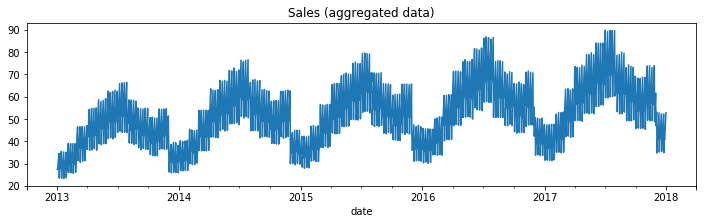

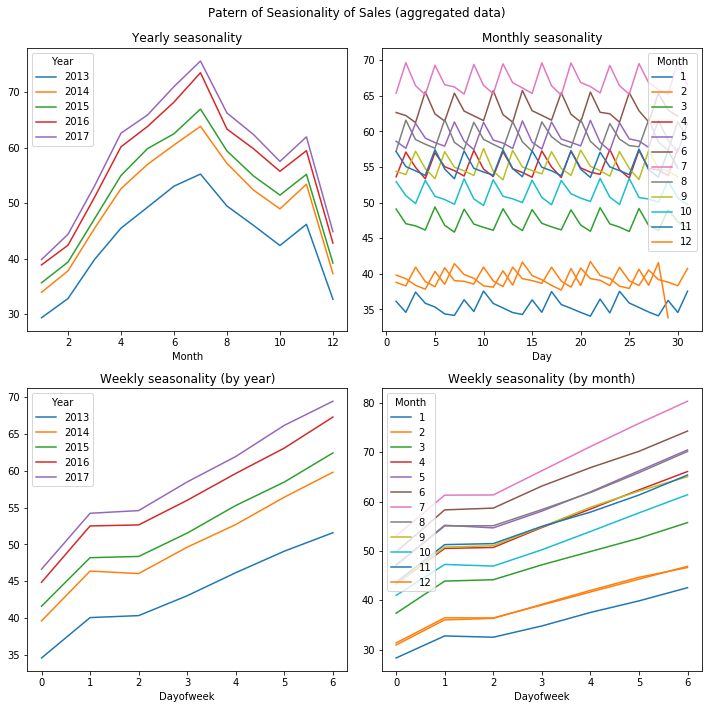

In [17]:
df_trainext.groupby('date').mean()['sales'].plot(figsize=(12,3), title='Sales (aggregated data)')

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Day').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Patern of Seasionality of Sales (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

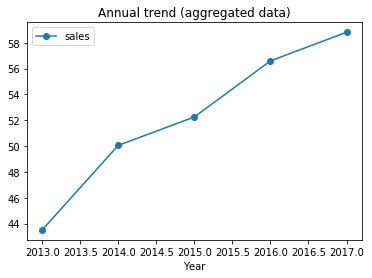

In [18]:
_ = pd.pivot_table(df_trainext, values='sales', index='Year').plot(style='-o', title="Annual trend (aggregated data)")


 * **Seasonal Trend Decomposition** using **Loess (STL)** decomposition

In [19]:
freq_season_mapping = {'None':None, 'Weekly': 7, 'Monthly':30, 'Yearly':365}

def update_stl_decompose(i_num, s_num, seasonality='Yearly', stl_style='additive'):
    ts = df_train.query('store == @s_num & item == @i_num').set_index('date')['sales']
    freq = freq_season_mapping[seasonality]
    
    fig, ax = plt.subplots(4, 1, figsize=(12,10))
    decomposition = sm.tsa.seasonal_decompose(ts, model=stl_style, freq=freq)
    _ = decomposition.observed.plot(ax=ax[0], title='observed')
    _ = decomposition.trend.plot(ax=ax[1], title='trend')
    _ = decomposition.seasonal.plot(ax=ax[2], title='seasonal')
    _ = decomposition.resid.plot(ax=ax[3], title='residual')
    res = decomposition.resid.values
    res = res[np.isfinite(res)]
# #     adfuller_stat = statsmodels.tsa.stattools.adfuller(res)
#     ljungbox_stat = statsmodels.stats.diagnostic.acorr_ljungbox(res)
#     statsmodels.graphics.tsaplots.plot_pacf(res, ax=ax[4], lags=40, 
#                                            title='residuals pacf; ljung-box p-value = {:.2E} / {:.2E}'.format(ljungbox_stat[1][6], 
#                                                                                                               ljungbox_stat[1][30]))
    fig.suptitle('STL decomposition')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
s_slider = widgets.IntSlider(min=1, max=10, continuous_update=False, description='store', layout={'width': '2.1in', 'height': '1in'})
i_slider = widgets.IntSlider(min=1, max=50, continuous_update=False, description='item', layout={'width': '2.1in', 'height': '1in'})
season_drop = widgets.Dropdown(value='Yearly', options=['Weekly', 'Monthly', 'Yearly'], description='seasonality', layout={'width': '2.1in'})
stltype_drop = widgets.Dropdown(value='multiplicative', options=['additive', 'multiplicative'], description='STL type', layout={'width': '2.1in'})
ui = widgets.HBox([s_slider, i_slider, season_drop, stltype_drop], layout={'min_width': '6in', 'max_width': '6in'})
out = widgets.interactive_output(update_stl_decompose, {'s_num': s_slider, 'i_num': i_slider, 
                                                        'seasonality': season_drop, 'stl_style': stltype_drop})
display(ui, out)

Output()

* Lag Auto-Correlation plot

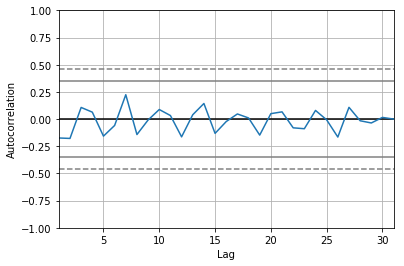

In [20]:
autocorrelation_plot(pd.pivot_table(df_trainext,values='sales',index='Day'))


# Training Forecast Model by Encoder-Decoder LSTM

In [21]:
def split_dataset(data,hor=7):
    # split into standard weeks
    data=data.iloc[6:]
    data_split=np.array(np.split(data.values, round(len(data)/hor)))
    train,test=data_split[:248],data_split[248:]
#     train, test = data.loc[:'2017-10-01'], data.loc['2017-10/-01':]
    # restructure into windows of weekly data
#     train = np.array(np.split(train.values, round(len(train)/hor)))
#     test = np.array(np.split(test.values, round(len(test)/hor)))
    return train, test

In [22]:
data_agg=pd.pivot_table(df_train,values='sales',index='date')
train,test=split_dataset(data_agg,7)

In [23]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [24]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores,model

In [25]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [26]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [27]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [28]:
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(300, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(300, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [29]:
# evaluate model and get scores
n_input = 7
score, scores,model = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = [ 'Sunday', 'Monday', 'Tuesday', 'Wednsday', 'Thursday', 'Friday','Saturday']
plt.plot(days, scores, marker='o', label='lstm')
plt.ylabel('RMSE')
plt.show()

NameError: name 'Sequential' is not defined